<a href="https://colab.research.google.com/github/adrien50/neuraltranslation/blob/main/neuraltranslationkeras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Neural Machine Translation with Seq2Seq in Keras

## Sequence-to-sequence Basics
Sequence-to-sequence, or “Seq2Seq”, is a relatively new paradigm, with its first published usage in 2014 for English-French translation . At a high level, a sequence-to-sequence model is an end-to-end model made up of two recurrent neural networks:

* an encoder, which takes the model’s input sequence as input and encodes it into a fixed-size “context vector”, and

* a decoder, which uses the context vector from above as a “seed” from which to generate an output sequence. For this reason, Seq2Seq models are often referred to as “encoder-decoder models.” We’ll look at the details of these two networks separately

## Seq2Seq architecture — encoder
The encoder network’s job is to read the input sequence to our Seq2Seq model and generate a fixed-dimensional context vector C for the sequence. To do so, the encoder will use a recurrent neural network cell — usually an LSTM — to read the input tokens one at a time. The final hidden state of the cell will then become C. However, because it’s so difficult to compress an arbitrary-length sequence into a single fixed-size vector (especially for difficult tasks like translation), the encoder will usually consist of stacked LSTMs: a series of LSTM “layers” where each layer’s outputs are the input sequence to the next layer. The final layer’s LSTM hidden state will be used as C.

## Seq2Seq architecture — decoder
The decoder is also an LSTM network, but its usage is a little more complex than the encoder network. Essentially, we’d like to use it as a language model that’s “aware” of the words that it’s generated so far and of the input. To that end, we’ll keep the “stacked” LSTM architecture from the encoder, but we’ll initialize the hidden state of our first layer with the context vector from above; the decoder will literally use the context of the input to generate an output. Once the decoder is set up with its context, we’ll pass in a special token to signify the start of output generation;

 we will see how to create a language translation model which is also a very famous application of neural machine translation. We will use seq2seq architecture to create our language translation model using Python's Keras library. reference https://machinelearningmastery.com/

## Libraries and Configuration Settings
As a first step, we will import the required libraries and will configure values for different parameters that we will be using in the code. Let's first import the required libraries:

## The Dataset
The language translation model that we are going to develop in this article will translate English sentences into their French language counterparts. To develop such a model, we need a dataset that contains English sentences and their French translations. Luckily, such dataset is freely available at this link. Download the file fra-eng.zip and extract it. You will then see the fra.txt file. On each line, the text file contains an English sentence and its French translation, separated by a tab.

The LSTM layer in the encoder is defined with the return_state argument set to True. This returns the hidden state output returned by LSTM layers generally, as well as the hidden and cell state for all cells in the layer. These are used when defining the decoder.

In [ ]:
from keras.models import Model
from keras.layers import Input
from keras.layers import LSTM
from keras.layers import Dense
from keras.utils.vis_utils import plot_model
# configure
num_encoder_tokens = 71
num_decoder_tokens = 93
latent_dim = 256

The LSTM layer in the encoder is defined with the return_state argument set to True. This returns the hidden state output returned by LSTM layers generally, as well as the hidden and cell state for all cells in the layer. These are used when defining the decoder.

In [ ]:
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

Next, we define the decoder.

The decoder input is defined as a sequence of French character one-hot encoded to binary vectors with a length of num_decoder_tokens.

The LSTM layer is defined to both return sequences and state. The final hidden and cell states are ignored and only the output sequence of hidden states is referenced.

Importantly, the final hidden and cell state from the encoder is used to initialize the state of the decoder. This means every time that the encoder model encodes an input sequence, the final internal states of the encoder model are used as the starting point for outputting the first character in the output sequence. This also means that the encoder and decoder LSTM layers must have the same number of cells, in this case, 256.

In [ ]:
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None, num_decoder_tokens))
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

Finally, the model is defined with inputs for the encoder and the decoder and the output target sequence

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

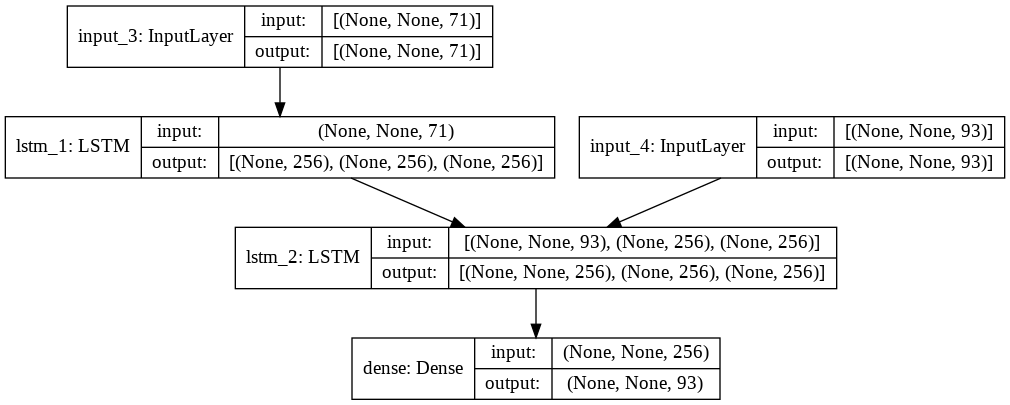

In [ ]:
# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
# plot the model
plot_model(model, to_file='model.png', show_shapes=True)

Note that the encoder LSTM does not directly pass its outputs as inputs to the decoder LSTM; as noted above, the decoder uses the final hidden and cell states as the initial state for the decoder.

Also note that the decoder LSTM only passes the sequence of hidden states to the Dense for output, not the final hidden and cell states as suggested by the output shape information.

Neural Machine Translation Inference

Once the defined model is fit, it can be used to make predictions. Specifically, output a French translation for an English source text.

The model defined for training has learned weights for this operation, but the structure of the model is not designed to be called recursively to generate one character at a time.

Instead, new models are required for the prediction step, specifically a model for encoding English input sequences of characters and a model that takes the sequence of French characters generated so far and the encoding as input and predicts the next character in the sequence.

Defining the inference models requires reference to elements of the model used for training in the example. Alternately, one could define a new model with the same shapes and load the weights from file.

The encoder model is defined as taking the input layer from the encoder in the trained model (encoder_inputs) and outputting the hidden and cell state tensors (encoder_states).

In [ ]:
# define encoder inference model
encoder_model = Model(encoder_inputs, encoder_states)

The decoder is more elaborate.

The decoder requires the hidden and cell states from the encoder as the initial state of the newly defined encoder model. Because the decoder is a separate standalone model, these states will be provided as input to the model, and therefore must first be defined as inputs.

In [ ]:
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))

In [ ]:
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)

Both the encoder and decoder will be called recursively for each character that is to be generated in the translated sequence.

On the first call, the hidden and cell states from the encoder will be used to initialize the decoder LSTM layer, provided as input to the model directly.

On subsequent recursive calls to the decoder, the last hidden and cell state must be provided to the model. These state values are already within the decoder; nevertheless, we must re-initialize the state on each call given the way that the model was defined in order to take the final states from the encoder on the first call.
Therefore, the decoder must output the hidden and cell states along with the predicted character on each call, so that these states can be assigned to a variable and used on each subsequent recursive call for a given input sequence of English text to be translated.


In [ ]:
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

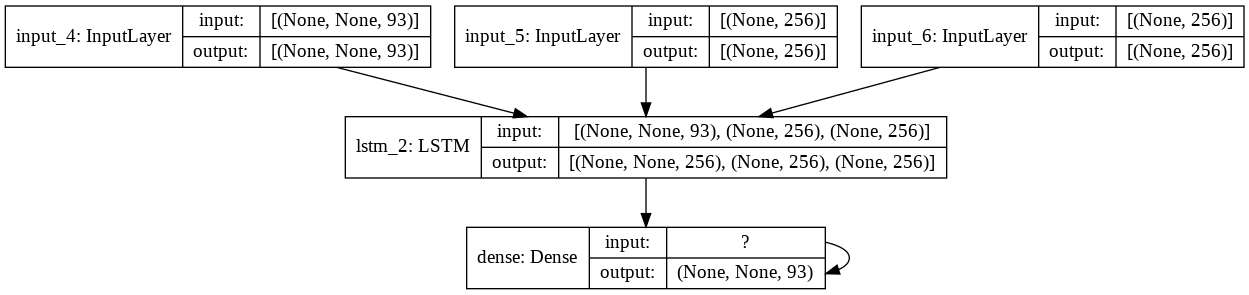

In [ ]:
# summarize model
plot_model(encoder_model, to_file='encoder_model.png', show_shapes=True)
plot_model(decoder_model, to_file='decoder_model.png', show_shapes=True)

The decoder shows the three inputs required to decode a single character in the translated sequence, the encoded translation output so far, and the hidden and cell states provided first from the encoder and then from the output of the decoder as the model is called recursively for a given translation.

